In [14]:
import glob
import pandas as pd
from src.utils import map_category
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from datasets import load_from_disk


In [15]:
stream_data = load_from_disk("data/processed/stream_data")


In [16]:
stream_data.set_format(type="pandas")
train_df = stream_data["train"][:]
valid_df = stream_data["validation"][:]


In [17]:
X_train, y_train = train_df["text"], train_df["label"]
X_valid, y_valid = valid_df["text"], valid_df["label"]
labels = stream_data["train"].features["label"].names


In [18]:
vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)


In [38]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
   
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3e}s")

    t0 = time()
    pred = clf.predict(X_valid)
    test_time = time() - t0
    print(f"inference time:  {test_time:.3e}s")

    balanced_accuracy = balanced_accuracy_score(y_valid, pred)
    print(f"Balanced accuracy score:    {balanced_accuracy:.3}")

    macro_f1 = f1_score(y_valid, pred, average="macro")
    print(f"Macro F1 score:    {macro_f1:.3}")

    weighted_f1 = f1_score(y_valid, pred, average="weighted")
    print(f"Weighted F1 score:    {weighted_f1:.3}")

    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, balanced_accuracy, macro_f1, weighted_f1, train_time, test_time


In [39]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

results = []
for clf, name in (
    (LogisticRegression(class_weight="balanced"), "Logistic Regression"),
    (RidgeClassifier(class_weight="balanced"), "Ridge Classifier"),
    (KNeighborsClassifier(), "kNN"),
    (RandomForestClassifier(class_weight="balanced"), "RandomForest Classifier"),
    (LinearSVC(class_weight="balanced"), "Linear SVC"),
    (SGDClassifier(class_weight="balanced"), "SGD Classifier"),
    (NearestCentroid(), "NearestCentroid"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))
    

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(class_weight='balanced')
train time: 1.470e+00s
inference time:  9.701e-04s
Balanced accuracy score:    0.692
Macro F1 score:    0.652
Weighted F1 score:    0.808
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(class_weight='balanced')
train time: 6.212e-01s
inference time:  0.000e+00s
Balanced accuracy score:    0.712
Macro F1 score:    0.662
Weighted F1 score:    0.814
kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.000e+00s
inference time:  6.799e-01s
Balanced accuracy score:    0.533
Macro F1 score:    0.569
Weighted F1 score:    0.798
RandomForest Classifier
________________________________________________________________________________
Training: 
RandomForestClassifier(class_weight='balanced

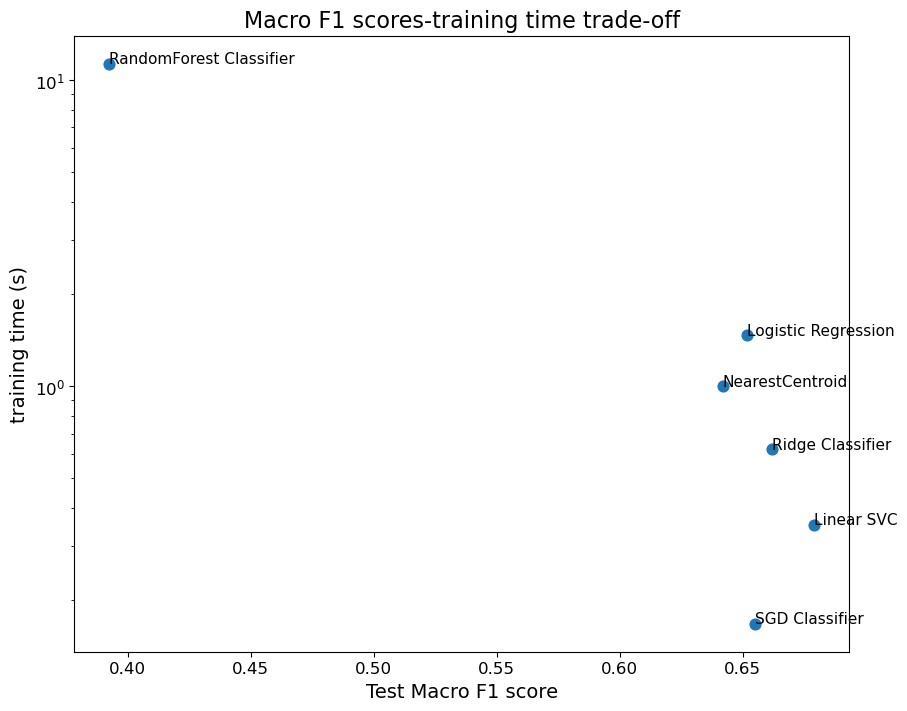

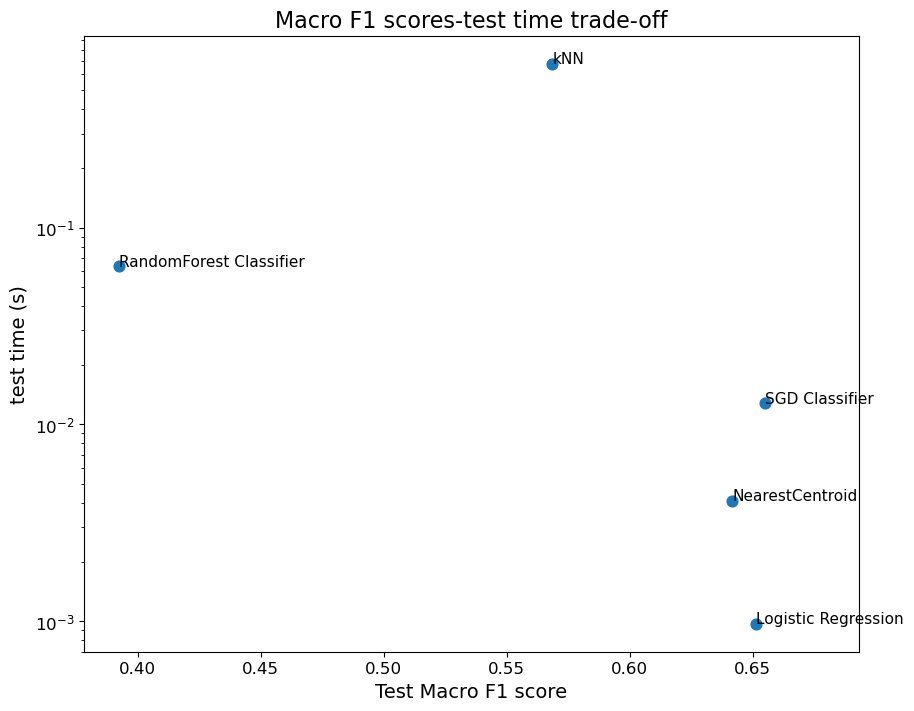

In [40]:
import numpy as np
import matplotlib.pyplot as plt  # Make sure matplotlib is imported

indices = np.arange(len(results))

# Extract all 6 elements from the results
metrics = [[x[i] for x in results] for i in range(6)]

# Unpack all 6 elements
clf_names, balanced_accuracy_scores, macro_f1_scores, weighted_f1_scores, training_time, test_time = metrics

training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(macro_f1_scores, training_time, s=60)
ax1.set(
    title="Macro F1 scores-training time trade-off",
    yscale="log",
    xlabel="Test Macro F1 score",
    ylabel="training time (s)",
)
# Increase font sizes for plot 1
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel("Test Macro F1 score", fontsize=14)
ax1.set_ylabel("training time (s)", fontsize=14)
ax1.set_title("Macro F1 scores-training time trade-off", fontsize=16)

fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(macro_f1_scores, test_time, s=60)
ax2.set(
    title="Macro F1 scores-test time trade-off",
    yscale="log",
    xlabel="Test Macro F1 score",
    ylabel="test time (s)",
)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel("Test Macro F1 score", fontsize=14)
ax2.set_ylabel("test time (s)", fontsize=14)
ax2.set_title("Macro F1 scores-test time trade-off", fontsize=16)

# Add text annotations to all plots with larger font
for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (macro_f1_scores[i], training_time[i]), fontsize=11)
    ax2.annotate(txt, (macro_f1_scores[i], test_time[i]), fontsize=11)

plt.show()


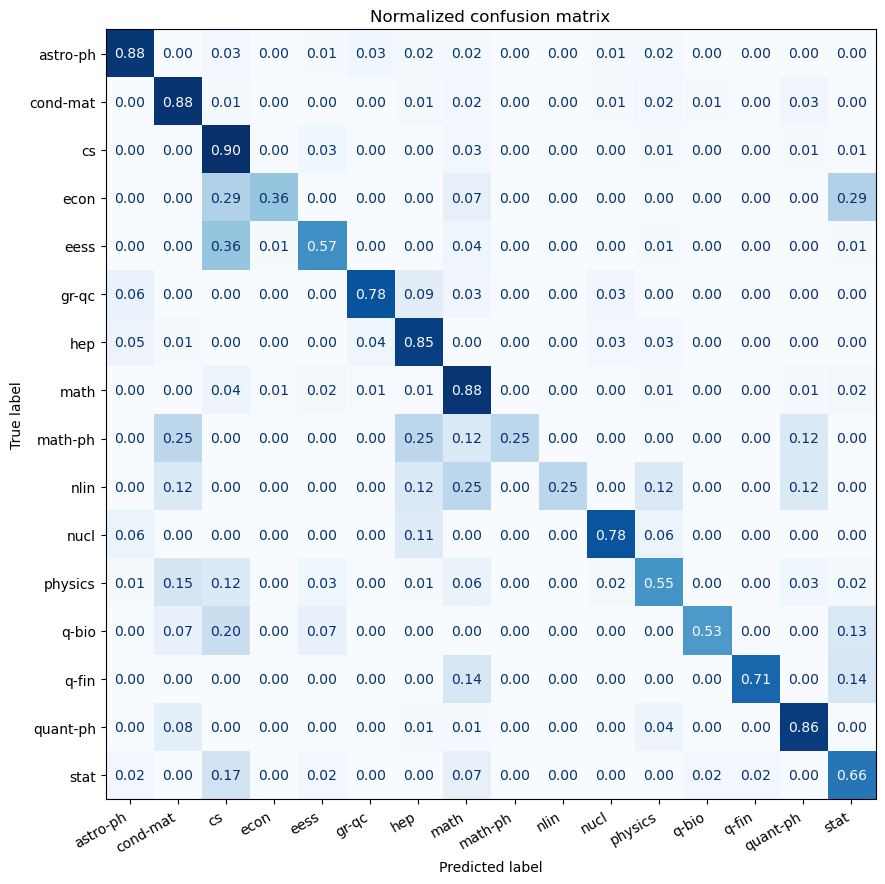

In [41]:
from src.utils import plot_confusion_matrix
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(class_weight="balanced", random_state=42)
svm_clf.fit(X_train, y_train)
y_preds = svm_clf.predict(X_valid)

plot_confusion_matrix(y_preds, y_valid, labels)


In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.91      0.88      0.89       120
    cond-mat       0.78      0.88      0.83       137
          cs       0.90      0.90      0.90       818
        econ       0.45      0.36      0.40        14
        eess       0.55      0.57      0.56        84
       gr-qc       0.74      0.78      0.76        32
         hep       0.80      0.85      0.82        79
        math       0.86      0.88      0.87       331
     math-ph       0.67      0.25      0.36         8
        nlin       1.00      0.25      0.40         8
        nucl       0.67      0.78      0.72        18
     physics       0.72      0.55      0.62       123
       q-bio       0.62      0.53      0.57        15
       q-fin       0.71      0.71      0.71         7
    quant-ph       0.80      0.86      0.83        90
        stat       0.57      0.66      0.61        41

    accuracy                           0.83      1925
   macro avg       0.73   